# Import

In [1]:
#import data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

import warnings
warnings.filterwarnings("ignore")

import torch
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_row', 50)

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

# Load data and split

In [2]:
path = 'data/'

train = pd.read_csv(path+'mod_train_rating_10n.csv')
#test = pd.read_csv(path+'mod_test_rating_10n.csv')

print(train.shape)
#print(test.shape)

(306795, 10)


In [3]:
train.head()

,user_id,isbn,rating,book_author,publisher,language,category_high,years,fix_location_state,fix_age
0,8.0,0002005018,4.0,others,Flamingo,en,actresses,2020,ontario,10
1,8.0,074322678X,4.0,Ann Beattie,Scribner,en,fiction,2020,ontario,10
2,8.0,0887841740,2.0,others,others,en,fiction,2020,ontario,10
3,8.0,1552041778,2.0,others,Mira,en,fiction,2000,ontario,10
4,8.0,1567407781,6.0,Loren D. Estleman,Brilliance Audio,en,fiction,2000,ontario,10


In [4]:
target = 'rating'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [5]:
print(train_indices)

Int64Index([     0,      2,      3,      4,      5,      6,      8,      9,
                10,     13,
            ...
            306782, 306783, 306784, 306785, 306786, 306787, 306788, 306792,
            306793, 306794],
           dtype='int64', length=245332)


# Simple preprocessing

In [6]:
train.dtypes

user_id               float64
isbn                   object
rating                float64
book_author            object
publisher              object
language               object
category_high          object
years                   int64
fix_location_state     object
fix_age                 int64
Set                    object
dtype: object

In [7]:
train.head()

,user_id,isbn,rating,book_author,publisher,language,category_high,years,fix_location_state,fix_age,Set
0,8.0,0002005018,4.0,others,Flamingo,en,actresses,2020,ontario,10,train
1,8.0,074322678X,4.0,Ann Beattie,Scribner,en,fiction,2020,ontario,10,test
2,8.0,0887841740,2.0,others,others,en,fiction,2020,ontario,10,train
3,8.0,1552041778,2.0,others,Mira,en,fiction,2000,ontario,10,train
4,8.0,1567407781,6.0,Loren D. Estleman,Brilliance Audio,en,fiction,2000,ontario,10,train


In [8]:
# Label encode categorical features and fill empty cells.
from sklearn.preprocessing import LabelEncoder

categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()  # 문자를 정수형 자료로 변환시켜주는 인코더(수치화)
    train[col] = train[col].fillna("VV_likely") # 결측값 채우기 해당 값은 뭘까? col이 달라도 상관없이 얘가 들어가는데..
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)
    print(categorical_columns, categorical_dims[col])

# object 타입의 변수들을 인코딩해서 카테고리컬 변수로 넣어주기

for col in train.columns[train.dtypes == 'float64']:    # 실수형 자료 결측값 채우기
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

isbn 129777
['isbn'] 129777
book_author 2102
['isbn', 'book_author'] 2102
publisher 1190
['isbn', 'book_author', 'publisher'] 1190
language 11
['isbn', 'book_author', 'publisher', 'language'] 11
category_high 209
['isbn', 'book_author', 'publisher', 'language', 'category_high'] 209
fix_location_state 234
['isbn', 'book_author', 'publisher', 'language', 'category_high', 'fix_location_state'] 234
Set 3
['isbn', 'book_author', 'publisher', 'language', 'category_high', 'fix_location_state', 'Set'] 3


# Define categorical features for categorical embeddings

In [9]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice (Optional)
#cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

# Network parameters

In [10]:
from pytorch_tabnet.tab_model import TabNetRegressor

clf = TabNetRegressor(cat_dims=cat_dims, cat_idxs=cat_idxs)
#cat_emb_dim=cat_emb_dim

In [11]:
print(features)

['user_id', 'isbn', 'book_author', 'publisher', 'language', 'category_high', 'years', 'fix_location_state', 'fix_age']


In [12]:
train.head()

,user_id,isbn,rating,book_author,publisher,language,category_high,years,fix_location_state,fix_age,Set
0,8.0,31,4.0,2101,401,3,2,2020,142,10,1
1,8.0,76197,4.0,83,938,3,123,2020,142,10,0
2,8.0,96808,2.0,2101,1189,3,123,2020,142,10,1
3,8.0,104143,2.0,2101,713,3,123,2000,142,10,1
4,8.0,107921,6.0,1254,158,3,123,2000,142,10,1


# Training

In [13]:
# X와 y의 형태 맞춰주기 -> n_tragets 값은 변경 가능
n_targets = 1

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
y_train = np.transpose(np.tile(y_train, (n_targets,1)))

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
y_valid = np.transpose(np.tile(y_valid, (n_targets,1)))

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
y_test = np.transpose(np.tile(y_test, (n_targets,1)))

In [16]:
print(X_train.shape, y_train.shape)

(245332, 9) (245332, 1)


In [17]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [18]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'], #['rmsle', 'mae', 'rmse', 'mse']
    max_epochs=max_epochs,
    patience=10,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

epoch 0  | loss: 7.13225 | train_rmse: 2.43913 | valid_rmse: 2.43113 |  0:00:23s
epoch 1  | loss: 5.91401 | train_rmse: 2.43564 | valid_rmse: 2.42841 |  0:00:46s
epoch 2  | loss: 5.87335 | train_rmse: 2.41243 | valid_rmse: 2.40729 |  0:01:09s
epoch 3  | loss: 5.81284 | train_rmse: 2.38455 | valid_rmse: 2.4048  |  0:01:32s
epoch 4  | loss: 5.66193 | train_rmse: 2.31949 | valid_rmse: 2.41268 |  0:01:55s
epoch 5  | loss: 5.3292  | train_rmse: 2.20848 | valid_rmse: 2.44089 |  0:02:18s
epoch 6  | loss: 4.92569 | train_rmse: 2.12672 | valid_rmse: 2.47978 |  0:02:46s
epoch 7  | loss: 4.59521 | train_rmse: 2.0667  | valid_rmse: 2.52559 |  0:03:09s
epoch 8  | loss: 4.36637 | train_rmse: 2.01027 | valid_rmse: 2.5532  |  0:03:32s
epoch 9  | loss: 4.1819  | train_rmse: 1.9614  | valid_rmse: 2.60155 |  0:03:55s
epoch 10 | loss: 4.02562 | train_rmse: 1.92148 | valid_rmse: 2.64751 |  0:04:18s
epoch 11 | loss: 3.88352 | train_rmse: 1.8994  | valid_rmse: 2.642   |  0:04:41s
epoch 12 | loss: 3.78326 | t

In [19]:
preds = clf.predict(X_test)

test_rmse = mean_squared_error(y_pred=preds, y_true=y_test)**0.5

print(f"BEST VALID SCORE FOR bookrec : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR bookrec : {test_rmse}")

BEST VALID SCORE FOR bookrec : 2.404801638584884
FINAL TEST SCORE FOR bookrec : 2.407831429792227


In [20]:
preds.shape

(30582, 1)

# Global explainability : feat importance summing to 1

In [21]:
clf.feature_importances_

array([0.00313126, 0.15324788, 0.08402489, 0.00495506, 0.04931256,
       0.33417186, 0.03004712, 0.02443112, 0.31667825])

In [22]:
clf.feature_importances_.shape

(9,)

# Local explainability and masks

In [23]:
explain_matrix, masks = clf.explain(X_test)

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

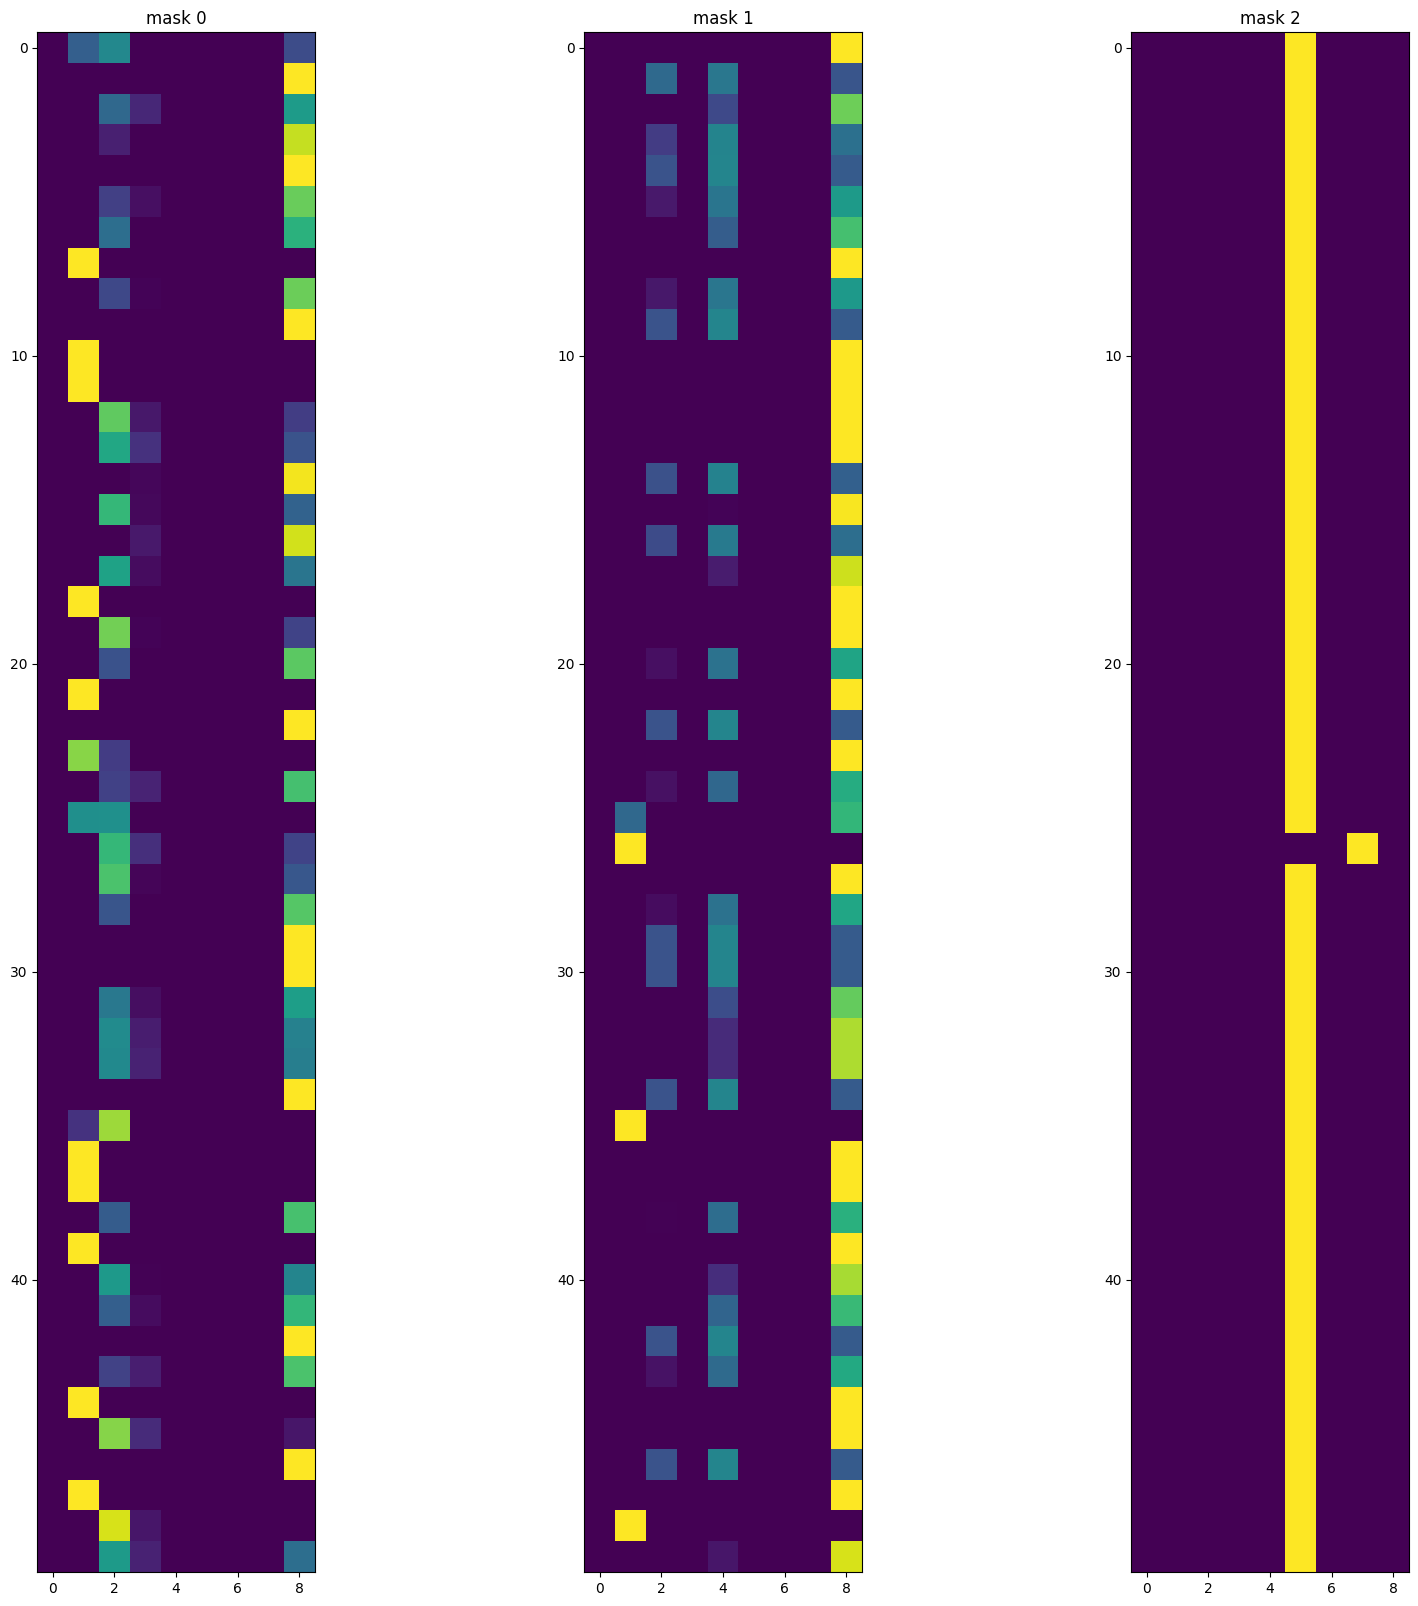

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [26]:
explain_matrix.shape

(30582, 9)

In [27]:
masks.keys()

dict_keys([0, 1, 2])

# Submit

In [41]:
submit = pd.read_csv(path+'mod_test_rating_10n.csv')
print(submit.shape)

(76699, 10)


In [42]:
submit["Set"] = 'submit'

submit_indices = submit.index

In [43]:
# Label encode categorical features and fill empty cells.
from sklearn.preprocessing import LabelEncoder

for col in submit.columns[submit.dtypes == object]:
    print(col, submit[col].nunique())
    l_enc = LabelEncoder()  # 문자를 정수형 자료로 변환시켜주는 인코더(수치화)
    submit[col] = submit[col].fillna("VV_likely") # 결측값 채우기 해당 값은 뭘까? col이 달라도 상관없이 얘가 들어가는데..
    submit[col] = l_enc.fit_transform(submit[col].values)

# object 타입의 변수들을 인코딩해서 카테고리컬 변수로 넣어주기

for col in submit.columns[submit.dtypes == 'float64']:    # 실수형 자료 결측값 채우기
    submit.fillna(submit.loc[submit_indices, col].mean(), inplace=True)

isbn 52000
book_author 2093
publisher 1174
language 11
category_high 207
fix_location_state 233
Set 1


In [44]:
X_submit = submit[features].values[submit_indices]
y_submit = submit[target].values[submit_indices]
y_submit = np.transpose(np.tile(y_submit, (n_targets,1)))

In [48]:
submit_preds = clf.predict(X_submit)

In [46]:
X_test

array([[8.00000e+00, 7.61970e+04, 8.30000e+01, ..., 2.02000e+03,
        1.42000e+02, 1.00000e+01],
       [1.14000e+04, 4.17720e+04, 1.48500e+03, ..., 2.00000e+03,
        1.42000e+02, 5.00000e+01],
       [1.16760e+04, 4.18860e+04, 8.22000e+02, ..., 2.00000e+03,
        3.60000e+01, 1.00000e+01],
       ...,
       [2.73666e+05, 5.47540e+04, 2.10100e+03, ..., 2.02000e+03,
        3.60000e+01, 1.00000e+01],
       [2.76912e+05, 1.20000e+02, 2.10100e+03, ..., 2.00000e+03,
        2.20000e+02, 3.00000e+01],
       [2.78330e+05, 9.85840e+04, 2.10100e+03, ..., 1.99000e+03,
        1.08000e+02, 5.00000e+01]])

In [47]:
X_submit

array([[1.14000e+04, 3.34060e+04, 2.09200e+03, ..., 2.02000e+03,
        1.42000e+02, 5.00000e+01],
       [1.14000e+04, 1.96820e+04, 4.13000e+02, ..., 2.00000e+03,
        1.42000e+02, 5.00000e+01],
       [1.14000e+04, 1.22390e+04, 2.09200e+03, ..., 2.02000e+03,
        1.42000e+02, 5.00000e+01],
       ...,
       [2.77079e+05, 5.00380e+04, 2.09200e+03, ..., 2.02000e+03,
        2.50000e+01, 1.00000e+01],
       [2.77514e+05, 4.95180e+04, 2.09200e+03, ..., 2.00000e+03,
        1.31000e+02, 1.00000e+01],
       [2.77680e+05, 4.80330e+04, 2.09200e+03, ..., 2.00000e+03,
        1.46000e+02, 4.00000e+01]])

In [49]:
submit_preds

array([[6.901532 ],
       [7.476406 ],
       [7.328086 ],
       ...,
       [6.806209 ],
       [6.83507  ],
       [6.9672823]], dtype=float32)

# Save Submit

In [50]:
output = pd.read_csv(path+'sample_submission.csv')

In [51]:
output['rating'] = submit_preds

In [52]:
output

,user_id,isbn,rating
0,11676,0002005018,6.901532
1,116866,0002005018,7.476406
2,152827,0060973129,7.328086
3,157969,0374157065,6.991628
4,67958,0399135782,7.447005
...,...,...,...
76694,278543,1576734218,6.841472
76695,278563,3492223710,7.307286
76696,278633,1896095186,6.806209
76697,278668,8408044079,6.835070


In [55]:
output.to_csv('submit/20221028_TabNet.csv', index = False)